In [16]:
import tweepy
import pandas as pd
from pyspark.sql import functions as F
import numpy as np
import json
from dotenv import load_dotenv
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

# Inicializar o cliente do Tweepy
client = tweepy.Client(consumer_key=os.getenv('TWEEPY_CONSUMER_KEY')
                     , consumer_secret=os.getenv('TWEEPY_CONSUMER_SECRET')
                     , bearer_token=os.getenv('TWEEPY_BEARER_TOKEN')
                     , access_token=os.getenv('TWEEPY_ACCESS_TOKEN')
                     , access_token_secret=os.getenv('TWEEPY_ACCESS_TOKEN_SECRET')
                     , wait_on_rate_limit = True)

In [5]:
client.get_user(username='amhikaetc').data.data['id']

AttributeError: 'NoneType' object has no attribute 'data'

In [3]:
class tweets:
    
    def __init__(self, username: str):
        self._username = username
        self._userId = client.get_user(username=self._username).data.data['id']

    def return_tweets_dataframe(self, nr_results = None):
        """
        Description:
            Return a pandas DataFrame wich contains tweets from a user.
            The DataFrame has the following schema:
                date: Date the tweet was posted in format %Y-%m-%d %H:%M:%S.
              , id_tweet: Unique identifier of tweet.
              , text: Tweet content.
              , likes: Total number of likes.
              , users_likes: A key-value pair containing id and username from users who liked the tweet.
        Args:
            nr_results = Number of tweets. The Tweepy API only supports 100 tweets per request.
        
        Authors:
            @marcuscardona
        
        Since 01-2023.
        """

        # Setar número de resultados
        if nr_results in range(0, 101, 1):
            max_results = (100 if nr_results is None else nr_results)
        else:
            max_results = 100
            print('O número de resultados foi setado para 100')
        # Retornar os tweets do usuário
        tweets = client.get_users_tweets(id = self._userId
                                       , max_results = max_results
                                       , tweet_fields = ['created_at'])

        # Listas vazias para as informações retornadas por loop
        id_tweet_list = []
        text_tweet_list = []
        likes_count_tweet_list = []
        likes_users_tweet_list  = []
        date_tweet_list = []

        for tweet in tweets.data:
            id_tweet = tweet.id
            text_tweet = tweet.text
            date_tweet = tweet.created_at.strftime("%Y-%m-%d %H:%M:%S")
            #
            liked_tweet_object = client.get_liking_users(id = id_tweet)
            
            likes_count_tweet = liked_tweet_object.meta['result_count']
            # Retornar usuários que curtiram o tweet
            likes_users_tweet_dict = {}
            try:
                for i in liked_tweet_object.data:
                    id_user_like = i['id']
                    username_user_like = i['username']
                    likes_users_tweet_dict.update({id_user_like:username_user_like})
            except:
                pass
            
            # Apendar todas as informações
            date_tweet_list.append(date_tweet)
            id_tweet_list.append(id_tweet)
            text_tweet_list.append(text_tweet)
            likes_count_tweet_list.append(likes_count_tweet)
            likes_users_tweet_list.append(likes_users_tweet_dict)

        # Colunas para criar DF
        columns_to_stack = [
            date_tweet_list,id_tweet_list, text_tweet_list
          , likes_count_tweet_list,likes_users_tweet_list
            ]
        columns_names = [
            'date', 'id_tweet', 'text'
          , 'likes', 'users_likes'
        ]

        # Criar DataFrame
        df = pd.DataFrame(np.column_stack(columns_to_stack), columns = columns_names)
        df.insert(loc=1, column='username', value=self._username)

        return df

In [7]:
t = tweets(username='milfprecoce')
teste=t.return_tweets_dataframe(nr_results = 10)
teste

,date,username,id_tweet,text,likes,users_likes
0,2023-02-02 20:20:44,milfprecoce,1621242232148840449,@missabreve só faz gritar fi,0,{}
1,2023-02-02 20:19:09,milfprecoce,1621241834570670080,RT @coutoartdump: tragédia moderna https://t.c...,0,{}
2,2023-02-02 20:18:58,milfprecoce,1621241791126163456,fico vendo esse alface do bbb e pensando puts ...,0,{}
3,2023-02-01 19:23:32,milfprecoce,1620865451801874432,RT @mateusofofo_: glr postei trabalho novo no ...,0,{}
4,2023-02-01 16:49:52,milfprecoce,1620826780524478464,"RT @jotagveiga: - hello, shiv roy from season ...",0,{}
5,2023-02-01 16:49:02,milfprecoce,1620826570968678400,to tao maluca overwhelmed trabalhando odiando ...,3,"{961703371718713344: 'danicatzs', 2752082320: ..."
6,2023-02-01 16:37:32,milfprecoce,1620823674063589376,RT @charli_xcx: caroline this is why i love yo...,0,{}


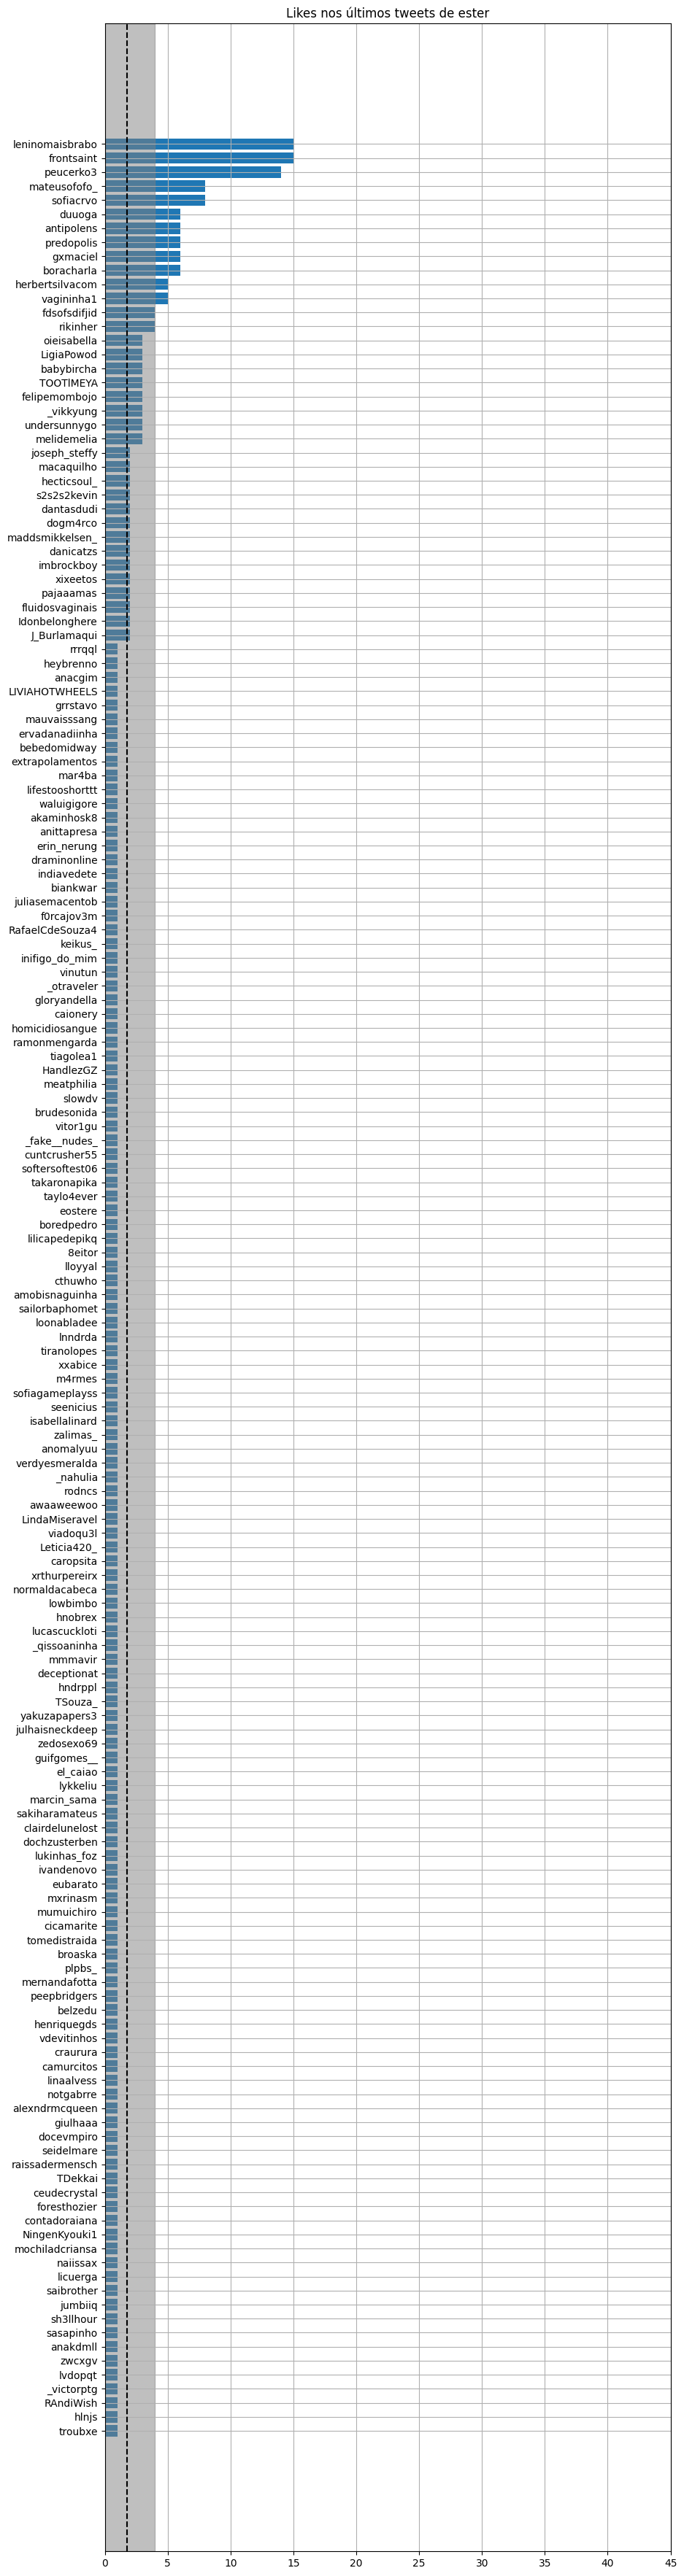

In [18]:
plt.figure(figsize=(10,45))
plt.barh('Usuario', 'Likes', data=likers_dataframe.sort_values('Likes'))
plt.axvline(likers_dataframe['Likes'].mean(), c='black', linestyle='dashed')
plt.axvspan(likers_dataframe['Likes'].mean() - likers_dataframe['Likes'].std(), likers_dataframe['Likes'].mean()+likers_dataframe['Likes'].std(), color='gray', alpha=0.5)
plt.xlim([0,45])
plt.title('Likes nos últimos tweets de ester')
plt.grid()
plt.show
plt.savefig('ester_likers.pdf')